## Part 3: Embeddings for shape classification

In this notebook, we will learn how train a neural network to classify cells based on their shapes. In order to do that, we will create an embeddings space...

In [1]:
import os
import h5py
import numpy as np
import random
import tifffile
import matplotlib.pyplot as plt

from shape_embeddings.data_utils import load_data
from shape_embeddings.criterion import DiscriminiativeLoss
from supervised_contrastive.utils import show_image, visualize_data

### 0. Data loading and preprocessing

For this exercise we will be using a dataset of wild-type (LMNA++) and lamin-deficient (LMNA--) mouse embryonic fibroblasts. Let's start with visualizing the data.

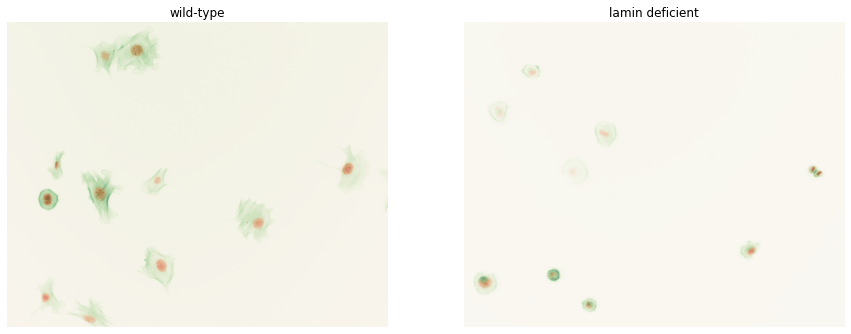

In [2]:
plt.rcParams['figure.figsize'] = [15, 8]
visualize_data()

The wild-type cells contain mixed shape profiles, whereas the lamin deficient cells have mostly a circular profile. In order to train our model, we will represent each cell as a 2D point cloud by sampling along a cells contour. More specifically, we take the segmentation mask of each cell, extract its contour and sample it.

<p float="left">
  <img src="images/instances2points.png" width="786" height="786"/>
</p>

**TASK 1:** Write a function that takes the instance segmenation (provided in the path below) and extracts a 2D point cloud for each cell in the image.

In [3]:
# Load instance segmentation
path_to_instance_seg = 'data/MEF_LMNA/xy001c1_instances.h5'

with h5py.File(path_to_instance_seg, 'r') as h5file:
    masks = h5file['exported_data'][:, :, 0]

# TODO: write function instances2points(masks: np.ndarray) -> [pointcloud1, ...., pointcloudN]

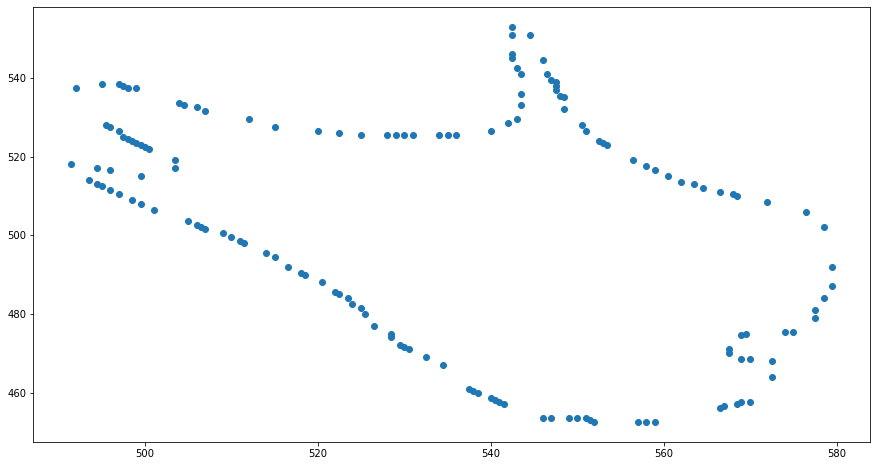

In [4]:
# Load instance segmentation
path_to_instance_seg = 'data/MEF_LMNA/xy001c1_instances.h5'

with h5py.File(path_to_instance_seg, 'r') as h5file:
    masks = h5file['exported_data'][:, :, 0]
    
# Solution
from skimage.measure import find_contours
from skimage.segmentation.boundaries import find_boundaries

def instances2points(masks):
    boundaries = find_boundaries(masks)
    contours = find_contours(boundaries)
    # Since the segmentation is not perfect, we neglect small artifacts
    contours = [c for c in contours if len(c) > 150]
    # sample 150 random points along the contour
    point_clouds = []
    for c in contours:
        indices = np.random.choice(len(c), size=150, replace=False)
        point_clouds += [c[indices]]
    return point_clouds

# visualize one point cloud
points = instances2points(masks)[8]
plt.scatter(points[:, 0], points[:, 1])
plt.show()

Next we have to implement a dataset - a class from which data can be sampled to train the network. A common practice is to integrate data augmentation into the dataset class, which we will do as well. Lastly the dataset is given to a sampler (also called data loader) such that samples can be fetched from it. Since we are not focusing on data handling, we will provide you with the necessary functionality. 

In [6]:
from torch.utils.data import Dataset, DataLoader
from supervised_contrastive.data_handling import get_MEF_loaders
from supervised_contrastive.utils import Center, RandomCoordsFlip, RandomNoise

class MEFDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()
        self.dataset = dataset
        self.base_transform = Center()
        self.transforms = transforms

    def apply_transforms(self, pts):
        for transform in self.transforms:
            pts = transform(pts)
        return pts

    def __getitem__(self, idx):
        label, pts = self.dataset[idx]
        pts = self.base_transform(pts)
        if self.transforms:
            pts = self.apply_transforms(pts)
        return (label, pts.astype(np.float32))

    def __len__(self):
        return len(self.dataset)


def get_MEF_loaders(path_to_dataset, batch_size=10, transforms=None):
    # Load data from storage
    mef_data = np.load(path_to_dataset, allow_pickle=True).item()
    data = []
    for key, pts in mef_data.items():
         # we asign label 0 to the wild-type and 1 to the lamin deficient cell
        label = 0 if 'wildtype' in key else 1
        data += [(label, pts.T)]
    random.shuffle(data)
    # Split data into training and validation set
    split_index = int(len(data) * 0.75)
    train_data = MEFDataset(data[:split_index], transforms)
    val_data = MEFDataset(data[split_index:])

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1)
    return train_loader, val_loader

### 1. The model: PointNet

TODO: Intuitive explanation of PointNet

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from supervised_contrastive.model import SpatialTransformer3d, SpatialTransformerkd

class PointNetFeat(nn.Module):
    def __init__(self, channels, global_feat=True, feature_transform=False):
        super().__init__()
        self.transformer = SpatialTransformer3d(channels)
        if feature_transform:
            self.feat_transformer = SpatialTransformerkd(channels, k=channels)
        self.conv1 = nn.Conv1d(2, channels, 1)
        self.conv2 = nn.Conv1d(channels, 2*channels, 1)
        self.conv3 = nn.Conv1d(2*channels, 16*channels, 1)

        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(2*channels)
        self.bn3 = nn.BatchNorm1d(16*channels)

        self.channels = channels

        self.global_feat = global_feat
        self.feat_transform = feature_transform

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.transformer(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feat_transform:
            trans_feat = self.feat_transformer(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 16*self.channels)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 16*self.channels, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


class PointNet(nn.Module):
    def __init__(self, channels=64, embed_dim=16, feature_transform=False):
        super().__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetFeat(channels,
                                 global_feat=True,
                                 feature_transform=feature_transform)

        self.fc1 = nn.Linear(16*channels, 8*channels)
        self.fc2 = nn.Linear(8*channels, 4*channels)
        self.fc3 = nn.Linear(4*channels, embed_dim)

        self.dropout = nn.Dropout(p=0.3)

        self.bn1 = nn.BatchNorm1d(8*channels)
        self.bn2 = nn.BatchNorm1d(4*channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return x

### 3. Loss: supervised constrastive

The  idea behind contrastive learning is to pull together an anchor (the sample that is processed) and a 'positive' sample (same class) in embedding space, and push apart the anchor from 'negative' samples (different class).